In [69]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [70]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [71]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [72]:
data, info = tfds.load('tf_flowers', with_info=True)
print(data, info)
data.keys()

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>} tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\euiso\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    ur

dict_keys(['train'])

In [73]:
ds_train = data['train']
print(len(ds_train))

3670


In [74]:
print(len(ds_train))

ds_train = ds_train.map(lambda x:(tf.image.resize(x['image'], (224, 224)), x['label']))
ds_train = ds_train.shuffle(1000).batch(3670)
batch = next(iter(ds_train))
print(batch[0].shape, type(batch[0]), batch[1].shape, type(batch[1]))

3670
(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [75]:
images, labels = batch
print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [76]:
# 만든 데이터를 확인하기 위해 그림을 그려보면

import matplotlib.pyplot as plt

label_map = {
    0 : 'dandelion',
    1 : 'daisy',
    2 : 'tulip',
    3 : 'sunflower',
    4 : 'rose'
}

images = images.numpy() / 255
labels = labels.numpy()

print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'numpy.ndarray'> (3670,) <class 'numpy.ndarray'>


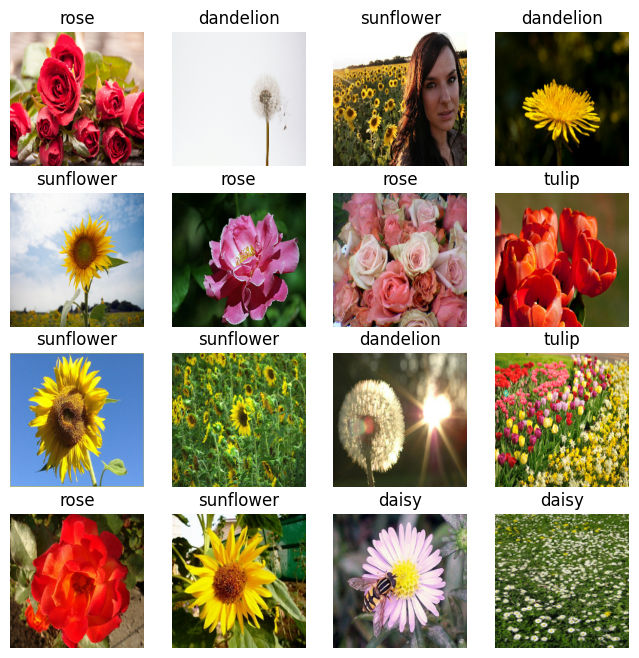

In [77]:
import random
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [78]:
# # 이미지 크기를 조정하고 numpy 배열로 변환
# def preprocess_data(dataset):
#     images = []
#     labels = []
#     for example in dataset:
#         image = example['image'].numpy() / 255.0  # 이미지 정규화
#         label = example['label'].numpy()
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# train_images, train_labels = preprocess_data(ds_train)

# print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))


In [79]:
# train, test 로 나누기 위해서 슬라이싱

train_images = images[:-600]
train_labels = labels[:-600]
val_images = images[-600 : -300]
val_labels = labels[-600 : -300]
test_images = images[-300:]
test_labels = labels[-300:]


print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(val_images.shape, type(val_images), val_labels.shape, type(val_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

(3070, 224, 224, 3) <class 'numpy.ndarray'> (3070,) <class 'numpy.ndarray'>
(300, 224, 224, 3) <class 'numpy.ndarray'> (300,) <class 'numpy.ndarray'>
(300, 224, 224, 3) <class 'numpy.ndarray'> (300,) <class 'numpy.ndarray'>


In [80]:
# torch tensor로 바꾸고, 모양도 (150, 150, 3) (3, 150, 150) 으로 바꾼다

import torch
train_images = torch.tensor(train_images).permute(0, 3, 1, 2)
val_images = torch.tensor(val_images).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images).permute(0, 3, 1, 2)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

torch.Size([3070, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([3070]) <class 'torch.Tensor'>
torch.Size([300, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([300]) <class 'torch.Tensor'>


In [81]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# CustomDataset 인스턴스 생성
train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)
test_dataset = CustomDataset(test_images, test_labels)

In [82]:
# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader 데이터 확인
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, {type(X)}, {y.dtype}")
    print(f"Shape of y: {y.shape}, {type(y)}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224]), <class 'torch.Tensor'>, torch.int64
Shape of y: torch.Size([64]), <class 'torch.Tensor'>, torch.int64


In [83]:
#########################################################################
#           간단한 훈련 코드
#########################################################################

In [84]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-6)

In [86]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).float(), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 3 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [87]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [88]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.611151  [   64/ 3070]
loss: 1.614524  [  256/ 3070]
loss: 1.604821  [  448/ 3070]
loss: 1.609305  [  640/ 3070]
loss: 1.604953  [  832/ 3070]
loss: 1.611894  [ 1024/ 3070]
loss: 1.610287  [ 1216/ 3070]
loss: 1.605593  [ 1408/ 3070]
loss: 1.618444  [ 1600/ 3070]
loss: 1.616665  [ 1792/ 3070]
loss: 1.602593  [ 1984/ 3070]
loss: 1.609530  [ 2176/ 3070]
loss: 1.609176  [ 2368/ 3070]
loss: 1.603311  [ 2560/ 3070]
loss: 1.613646  [ 2752/ 3070]
loss: 1.607129  [ 2944/ 3070]
Test Error: 
 Accuracy: 27.0%, Avg loss: 1.608520 

Epoch 2
-------------------------------
loss: 1.600249  [   64/ 3070]
loss: 1.612494  [  256/ 3070]
loss: 1.605290  [  448/ 3070]
loss: 1.603105  [  640/ 3070]
loss: 1.616632  [  832/ 3070]
loss: 1.605589  [ 1024/ 3070]
loss: 1.615962  [ 1216/ 3070]
loss: 1.601339  [ 1408/ 3070]
loss: 1.609682  [ 1600/ 3070]
loss: 1.608720  [ 1792/ 3070]
loss: 1.610257  [ 1984/ 3070]
loss: 1.604049  [ 2176/ 3070]
loss: 1.615244  [ 2368/ 3070

In [89]:
################################################################################
#     복잡한 훈련 코드
################################################################################

In [90]:
# import torch.nn.functional as F

# class NyCNNModel(nn.Module) :
    
#     def __init__(self) :
#         super(NyCNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x) :
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [91]:
# class MyCNNModel(nn.Module):

#     def __init__(self):

#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
#         self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

#         self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(7 * 7  * 256, 128) # (224, 224) 배열을 5번의 dropout 를 거치면서 224-112-56-28-14-7 로 변함....
#         self.fc2 = nn.Linear(128, 5) # 5개의 꽃 종류를 구별해 내므로 

#         self.dropout25 = nn.Dropout(p=0.25)
#         self.dropout50 = nn.Dropout(p=0.5)

#     def forward(self, data):

#         data = self.conv1(data)
#         data = torch.relu(data)
#         data = self.conv2(data)
#         data = torch.relu(data)
#         data = self.pooling(data)
#         data = self.dropout25(data)

#         data = self.conv3(data)
#         data = torch.relu(data)
#         data = self.conv4(data)
#         data = torch.relu(data)
#         data = self.pooling(data)
#         data = self.dropout25(data)

#         data = self.conv5(data)
#         data = torch.relu(data)
#         data = self.pooling(data)
#         data = self.dropout25(data)

#         data = self.conv6(data)
#         data = torch.relu(data)
#         data = self.pooling(data)
#         data = self.dropout25(data)

#         data = self.conv7(data)
#         data = torch.relu(data)
#         data = self.pooling(data)
#         data = self.dropout25(data)

#         data = data.view(-1, 1 * 1 * 256)

#         data = self.fc1(data)
#         data = torch.relu(data)
#         data = self.dropout50(data)

#         logits = self.fc2(data)

#         return logits
    
# model = MyCNNModel().to(device)
# print(model)

In [92]:
class MyCNNModel(nn.Module) :

    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

        self.fc1 =nn.Linear(7 * 7* 256, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x) :
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pooling(x)
        x = self.dropout25(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x= self.pooling(x)
        x = self.dropout25(x)

        x = F.relu(self.conv5(x))
        x = self.pooling(x)
        x = self.dropout25(x)

        x = F.relu(self.conv6(x))
        x = self.pooling(x)
        x = self.dropout25(x)

        x = F.relu(self.conv7(x))
        x = self.pooling(x)
        x = self.dropout25(x)

        x = x.view(-1, 7 * 7 * 256)

        x = F.relu(self.fc1(x))
        x = self.dropout50(x)

        x = F.relu(self.fc2(x))
        x = self.dropout50(x)

        logits = self.fc3(x)

        return logits
    
mosel = MyCNNModel().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [102]:
loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 2e-6)  #과적합의 문제가 심각함.
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [94]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(device)
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, dim=1)==y_train).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    trian_avg_accuracy = train_correct / train_total * 100

    return train_avg_loss, trian_avg_accuracy


In [97]:
def model_evaluate(dataloader, model, loss_function, optimizer) :

    model.eval()

    with torch.no_grad() : 

        val_loss_sum = val_correct = total_val = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader :

            x_val = images.to(device)
            y_val = labels.to(device)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            total_val += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1)==y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = val_correct / total_val * 100

        return val_avg_loss, val_avg_accuracy





In [103]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 100

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(test_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 7.473 train acc = 32.671 val loss = 1.400 val acc = 39.000
epoch: 02 train loss = 1.284 train acc = 44.463 val loss = 1.344 val acc = 45.000
epoch: 03 train loss = 1.260 train acc = 47.231 val loss = 1.236 val acc = 47.000
epoch: 04 train loss = 1.199 train acc = 50.098 val loss = 1.233 val acc = 46.333
epoch: 05 train loss = 1.146 train acc = 52.573 val loss = 1.326 val acc = 47.000
epoch: 06 train loss = 1.115 train acc = 52.769 val loss = 1.215 val acc = 50.667
epoch: 07 train loss = 1.145 train acc = 50.489 val loss = 1.235 val acc = 48.000
epoch: 08 train loss = 1.055 train acc = 57.590 val loss = 1.266 val acc = 47.667
epoch: 09 train loss = 1.014 train acc = 59.446 val loss = 1.322 val acc = 45.000
epoch: 10 train loss = 1.006 train acc = 58.762 val loss = 1.203 val acc = 51.333
epoch: 11 train loss = 0.981 train acc = 60.391 val loss = 1.335 val acc = 48.333
epoch: 12 train loss = 0.913 train acc = 65.505 val loss = 1.275 val acc = 50.333
epoch: 13 train 

In [104]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(device)
            y_test = labels.to(device)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [105]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_loader, model)

accuracy: 44.666666666666664
loss: 3.0075740814208984


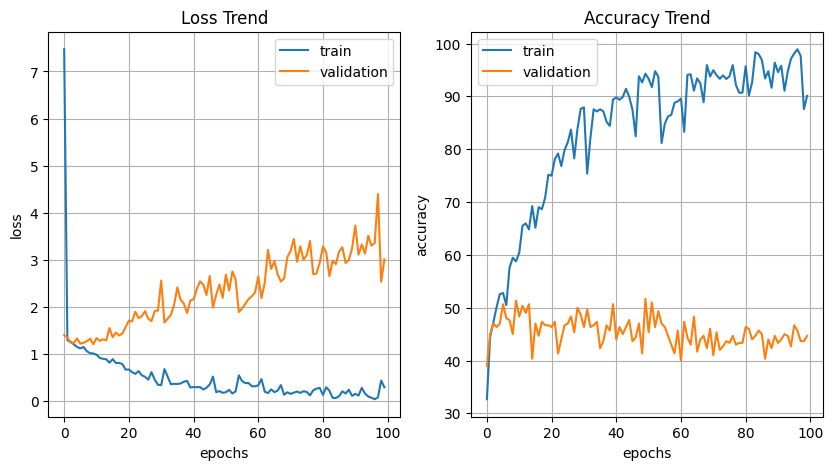

In [106]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()